In [1]:
import locale
import json
from pathlib import Path
from collections import defaultdict
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

# Para parsear fechas en español es necesario cambiar locales
locale.setlocale(locale.LC_ALL, 'es_ES')

'es_ES'

In [2]:
NEWS_FILE_PATH = Path("news.jl")

# Descripción del archivo

El archivo `news.jl` contiene el set de datos. Cada línea del archivo corresponde a un objeto JSON con el siguiente esquema:

```
{
  "url": "...",
  "title": "...",
  "subhead": "..."
  "date": "23 de Febrero de 2019",
  "time": "16:13",
  "agency": "...",
  "text": "...",
  "comments_url": "...",
  "comments": [
    {
      "id": 7684786,
      "avatar": "https://ugc.ecn.cl/upload/files/2019/02/02/IMG_20181224_162234_992.jpg",
      "creator": "marcela",
      "presence": "AWAY",
      "promotedCreator": false,
      "creatorId": 5410,
      "banned": false,
      "authSource": "pram",
      "validated": false,
      "location": "Santiago",
      "text": "&nbsp;mijo, renuncie, piense en el pueblo",
      "likes": 135,
      "dislikes": 9,
      "denounces": 1,
      "time": 1550951060000,
      "status": "APPROVED",
      "boost": 1,
      "highlight": false,
      "level": 0,
      "pageSection": "Internacional",
      "anchor": "C",
      "pageCmsId": 938913
    }, ...]
```

La generación del archivo `news.jl` se realiza mediante la ejecución del siguiente programa: `scrapy crawl news -o news.jl`. El trabajo demora aproximadamente 4 horas al ser ejecutado en el cluster en el DCC.

El archivo pesa 4.3GB descomprimido, al comprimirlo este valor disminuye a 917MB. Ambas versiones se encuentran disponibles en `scylla:/vault/xai/emol`.

# Exploración del set de datos

In [3]:
def count_words(string):
    return len(string.split())

In [31]:
# news
news_stats = defaultdict(list)

# comments
comments_stats = defaultdict(list)

with open(NEWS_FILE_PATH, "r") as news_file:
    for line in tqdm(news_file):
        news = json.loads(line)
        
        news_stats["urls"].append(news["url"])
        news_stats["num_words_per_title"].append(count_words(news["title"] if news["title"] is not None else ""))
        news_stats["num_words_per_subhead"].append(count_words(news["subhead"] if news["subhead"] is not None else ""))
        news_stats["num_words_per_body"].append(count_words(news["text"] if news["title"] is not None else ""))
        news_stats["num_comments"].append(len(news["comments"]))
        news_stats["dates"].append(datetime.strptime(news["date"], "%d de %B de %Y"))
        
        for comment in news["comments"]:
            comments_stats["ids"].append(comment["id"])
            comments_stats["newsIDs"].append(comment["pageCmsId"])
            comments_stats["likes"].append(comment["likes"])
            comments_stats["dislikes"].append(comment["dislikes"])
            comments_stats["denounces"].append(comment["denounces"])
            comments_stats["creatorIDs"].append(comment["creatorId"])
            comments_stats["num_words_per_comment"].append(count_words(comment["text"]))
            comments_stats["statuses"].append(comment["status"])
            comments_stats["dates"].append(datetime.strptime(news["date"], "%d de %B de %Y"))

In [5]:
news_df = pd.DataFrame.from_dict(news_stats)
len(news_df)

143340

In [39]:
comments_df = pd.DataFrame.from_dict(comments_stats)
len(comments_df)

6083910

Se observa que luego del scrapeo, se obtienen 143.340 noticias, junto a 6.083.910 comentarios. A continuación se mostraran las siguientes cualidades del set de datos.

- Número de palabras en títulos, bajadas y cuerpos de noticias.
- Número de comentarios por noticias.
- Número de comentarios por usuario.
- Número de palabras en comentarios.
- Número de likes y dislikes por comentario.
- Números de denuncias de comentarios.

## Número de palabras en títulos, bajadas y cuerpos de noticias

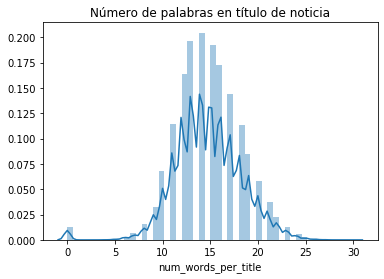

In [57]:
ax = sns.distplot(news_df["num_words_per_title"])
ax.set_title("Número de palabras en título de noticia")
pass

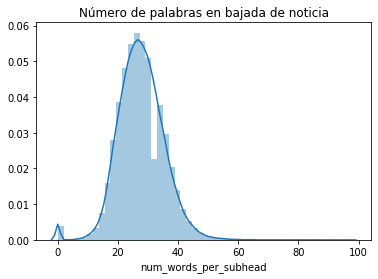

In [59]:
ax = sns.distplot(news_df["num_words_per_subhead"])
ax.set_title("Número de palabras en bajada de noticia")
pass

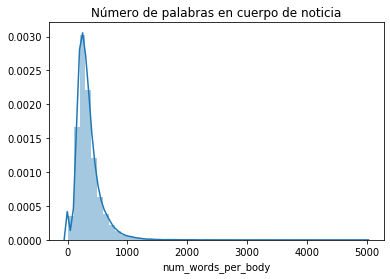

In [94]:
# Sin dos outliers
ax = sns.distplot(news_df["num_words_per_body"])
ax.set_title("Número de palabras en cuerpo de noticia")
pass

In [82]:
news_df["num_words_per_body"].describe()

count    143340.000000
mean        342.910513
std         217.080530
min           0.000000
25%         215.000000
50%         298.000000
75%         416.000000
max       18978.000000
Name: num_words_per_body, dtype: float64

In [98]:
news_df.sort_values(by="num_words_per_body", ascending=False).head(5)

,urls,num_words_per_title,num_words_per_subhead,num_words_per_body,num_comments,dates
3087,https://www.emol.com/noticias/Nacional/2019/01...,17,54,4974,104,2019-01-31
43449,https://www.emol.com/noticias/Nacional/2018/10...,15,36,4757,445,2018-10-04
39723,https://www.emol.com/noticias/Nacional/2017/08...,10,40,3996,17,2017-08-23
116693,https://www.emol.com/noticias/Internacional/20...,10,60,3946,202,2018-03-03
27282,https://www.emol.com/noticias/Nacional/2018/12...,20,22,3641,38,2018-12-17


In [93]:
news_df = news_df.drop([30616, 14338])
len(news_df)

143338

## Número de comentarios por noticia

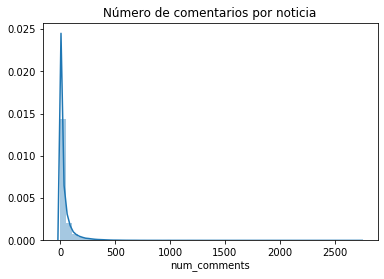

In [100]:
# Distribución
ax = sns.distplot(news_df["num_comments"])
ax.set_title("Número de comentarios por noticia")
pass

In [102]:
# Promedio y percentiles
news_df["num_comments"].describe()

count    143338.000000
mean         42.444293
std          82.529864
min           0.000000
25%           2.000000
50%          13.000000
75%          46.000000
max        2729.000000
Name: num_comments, dtype: float64

In [109]:
# Noticias más comentadas
for i in range(40):
    item = news_df.sort_values(by="num_comments", ascending=False).iloc[i]
    print(item.num_comments, item.urls)

2729 https://www.emol.com/noticias/Nacional/2016/08/23/818559/Encuesta-Estas-de-acuerdo-con-prohibir-el-rodeo.html
2078 https://www.emol.com/noticias/Nacional/2016/11/23/832568/Diputada-Vallejo-cita-a-la-Biblia-para-explicar-por-que-no-abrira-las-sesiones-de-comision-en-el-nombre-de-Dios.html
2060 https://www.emol.com/noticias/Nacional/2016/10/11/825998/Camila-Vallejo-No-fuimos-elegidos-para-legislar-en-nombre-de-Dios-sino-por-nuestros-principios.html
1912 https://www.emol.com/noticias/Tendencias/2016/06/18/808421/CONCURSO-Gana-una-exclusiva-chaqueta-para-hombres-Timberland-solo-hay-10-en-Chile.html
1871 https://www.emol.com/noticias/Nacional/2016/07/05/810948/Myriam-Olate-defiende-pension-de-5-millones-Es-la-que-corresponde-en-derecho.html
1655 https://www.emol.com/noticias/Nacional/2016/11/24/832727/Barbara-Figueroa-por-derrota-de-Gajardo-Existe-es-un-fuerte-anticomunismo-en-este-pais.html
1635 https://www.emol.com/noticias/Nacional/2016/01/29/785976/Bachelet-emocionada-tras-caso-Cav

## Número de comentarios por usuarios

In [112]:
# Número de usuarios
comments_df["creatorIDs"]

192551

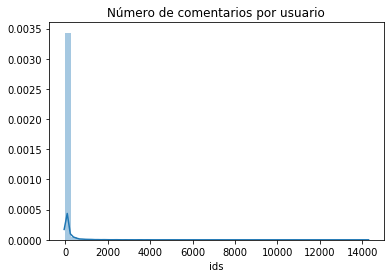

In [138]:
# Distribución
by_user = comments_df.groupby(by="creatorIDs")
num_comments_by_user = by_user["ids"].count()
ax = sns.distplot(num_comments_by_user)
ax.set_title("Número de comentarios por usuario")
pass

In [139]:
# Promedio y percentiles
num_comments_by_user.describe()

count    192551.000000
mean         31.596356
std         195.407716
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       14243.000000
Name: ids, dtype: float64

In [136]:
# Usuarios más comentadores
num_comments_by_user.sort_values(ascending=False).head(40)

creatorIDs
7729       14243
925        13817
1077       10810
370709      9087
241785      8917
143441      8714
1153126     8427
145         8375
156470      8129
1123574     8120
1243975     7807
4397        7746
984229      7576
222         7420
451291      7338
1023        7286
7416        7228
752         7203
401         7083
29          7042
673         6941
2530        6930
817486      6737
178         6538
15599       6538
177436      6282
1377        6203
19220       6128
1287539     6104
24761       6079
107         6051
216941      5984
2565        5984
62          5888
1348191     5710
2026        5688
161887      5630
913769      5589
1171609     5471
11965       5409
Name: ids, dtype: int64

## Número de palabras en comentarios

In [140]:
# Promedio y percentiles
comments_df["num_words_per_comment"].describe()

count    6.083910e+06
mean     3.027367e+01
std      3.533510e+01
min      1.000000e+00
25%      9.000000e+00
50%      1.900000e+01
75%      3.800000e+01
max      6.810000e+02
Name: num_words_per_comment, dtype: float64

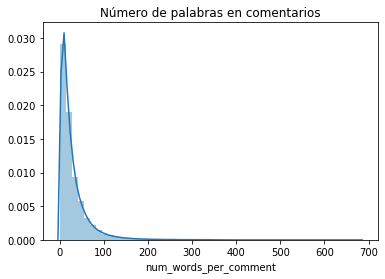

In [141]:
# Distribución
ax = sns.distplot(comments_df["num_words_per_comment"])
ax.set_title("Número de palabras en comentarios")
pass

In [142]:
# Comentarios con más palabras
comments_df.sort_values(by="num_words_per_comment", ascending=False).head(40)

,ids,newsIDs,likes,dislikes,denounces,creatorIDs,num_words_per_comment,statuses
2150356,1669882,814997,0,0,0,1359,681,PENDING
3018203,1043162,796732,0,0,0,117136,463,NEW
4437204,3029903,852085,1,3,0,3053,425,NEW
4434277,3029895,852068,5,2,0,3053,425,NEW
2944222,1489550,809816,0,0,0,32084,422,PENDING
3853801,3182197,853961,0,0,0,257318,410,NEW
3626887,1061842,797233,0,0,0,80030,409,PENDING
4612878,2792685,845736,7,0,0,81721,403,NEW
4134703,5563112,906922,6,4,0,292603,398,NEW
3883332,3123335,854734,1,0,0,269224,397,NEW


```
{
  "id": 1669882,
  "avatar": "https://imgcomentarista.emol.cl/images/59/1359_1528733479932.jpg",
  "creator": "Hector Ulloa",
  "presence": "AWAY",
  "page": "http://www.emol.com/noticias/Deportes/2016/07/30/814997/Beccacece-tras-la-derro-Insisto-en-la-conviccion-y-la-tranquilidad-que-uno-puede-transmitir-como-lider.html",
  "promotedCreator": false,
  "creatorId": 1359,
  "banned": false,
  "authSource": "facebook",
  "validated": false,
  "location": "Santiago",
  "text": "&nbsp;JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA JA",
  "likes": 0,
  "dislikes": 0,
  "denounces": 0,
  "time": 1469901836000,
  "status": "PENDING",
  "boost": 0,
  "highlight": false,
  "level": 1,
  "pageTitle": "Beccacece tras la derrota: 'Insisto en la convicci&oacute;n y la tranquilidad que uno puede transmitir como l&iacute;der'",
  "pageSection": "Deportes",
  "anchor": "C",
  "pageCmsId": 814997
},
{
  "id": 3029903,
  "avatar": "https://ugc.ecn.cl/upload/files/2018/12/27/6978749B-3E62-4D0D-81F5-741A93F6874A.jpeg",
  "creator": "Jordi Badaloní XXIII",
  "presence": "AWAY",
  "page": "http://www.emol.com/noticias/Deportes/2017/03/31/852085/En-Argentina-revelan-las-exigencias-que-pondria-Sampaoli-para-aceptar-ser-DT-de-la-seleccion.html",
  "promotedCreator": false,
  "creatorId": 3053,
  "banned": false,
  "authSource": "pram",
  "validated": true,
  "location": "Villarrica",
  "text": "&nbsp;URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR! URUGUAY LES VA A GANAR!",
  "likes": 1,
  "dislikes": 3,
  "denounces": 0,
  "time": 1490975150000,
  "status": "NEW",
  "boost": 0,
  "highlight": false,
  "level": 1,
  "pageTitle": "En Argentina revelan las exigencias que pondr&iacute;a Sampaoli para aceptar ser DT de la selecci&oacute;n",
  "pageSection": "Deportes",
  "anchor": "C",
  "pageCmsId": 852085
}
```

## Número de likes y dislikes por comentario

In [147]:
# Promedios y percentiles
comments_df["likes"].describe()

count    6.083910e+06
mean     4.337142e+00
std      9.402730e+00
min     -1.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      8.740000e+02
Name: likes, dtype: float64

In [149]:
comments_df["dislikes"].describe()

count    6.083910e+06
mean     1.822100e+00
std      5.383571e+00
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      6.890000e+02
Name: dislikes, dtype: float64

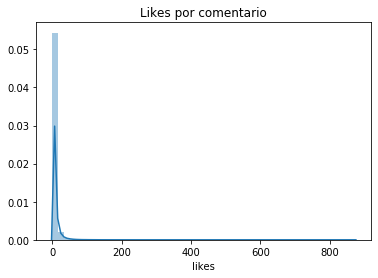

In [150]:
# Distribuciones
ax = sns.distplot(comments_df["likes"])
ax.set_title("Likes por comentario")
pass

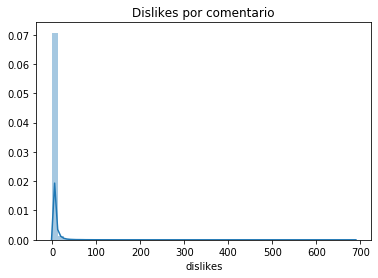

In [151]:
ax = sns.distplot(comments_df["dislikes"])
ax.set_title("Dislikes por comentario")
pass

In [152]:
comments_df.sort_values(by="likes", ascending=False).head(40)

,ids,newsIDs,likes,dislikes,denounces,creatorIDs,num_words_per_comment,statuses
2315126,3773344,871806,874,51,0,49241,16,APPROVED
2437590,3532841,865742,812,45,0,76088,59,APPROVED
2303538,3754193,871400,758,39,0,16515,11,APPROVED
1559267,3965317,876087,725,78,0,6288,17,APPROVED
1419521,4038639,877687,681,42,0,886625,19,NEW
455851,4558143,887812,656,14,0,965269,32,APPROVED
1321228,1803188,818559,643,174,2,122953,78,DENOUNCED
2303437,3754254,871400,640,24,1,108836,7,DENOUNCED
3221314,3222263,857373,640,72,4,33974,25,PENDING
1419026,4039400,877687,635,34,0,259335,113,APPROVED


```
{
  "id": 3773344,
  "avatar": "https://imgcomentarista.emol.cl/images/41/49241_1541528619188.jpg",
  "creator": "Carlos Borie O.",
  "presence": "AWAY",
  "page": "http://www.emol.com/noticias/Nacional/2017/08/20/871806/Cadem-Pinera-incrementa-su-respaldo-mientras-que-Sanchez-y-Guillier-retroceden.html",
  "promotedCreator": false,
  "creatorId": 49241,
  "banned": false,
  "authSource": "facebook",
  "validated": false,
  "text": "&nbsp;No hay que confiarse... Tenemos que ir a votar todos para que no haya segunda vuelta",
  "likes": 874,
  "dislikes": 51,
  "denounces": 0,
  "time": 1503231756000,
  "status": "APPROVED",
  "boost": 1,
  "highlight": false,
  "level": 1,
  "pageTitle": "Cadem: S&aacute;nchez y Guillier retroceden mientras Pi&ntilde;era incrementa su respaldo",
  "pageSection": "Nacional",
  "anchor": "C",
  "pageCmsId": 871806
}
```

In [153]:
comments_df.sort_values(by="dislikes", ascending=False).head(40)

,ids,newsIDs,likes,dislikes,denounces,creatorIDs,num_words_per_comment,statuses
1702438,6832623,926908,80,689,0,635604,23,APPROVED
4541058,2935589,849728,304,565,1,34875,24,DENOUNCED
4920354,5003157,896852,86,504,1,5993,339,DENOUNCED
1829718,6678353,924862,34,501,1,6193,38,DENOUNCED
4615612,2815681,846343,118,488,0,87259,65,APPROVED
1559312,3966461,876087,48,485,3,79375,22,DENOUNCED
1321259,1803486,818559,175,480,1,168592,73,DENOUNCED
3588998,5716682,909751,32,475,1,832,37,APPROVED
814368,4358647,884266,255,447,0,271016,29,APPROVED
5674572,7682304,938869,70,438,6,145,44,PENDING


```
{
  "id": 6832623,
  "avatar": "https://imgcomentarista.emol.cl/images/4/635604_1535643020366.jpg",
  "creator": "Camilo Baldimontti",
  "presence": "AWAY",
  "page": "http://www.emol.com/noticias/Nacional/2018/11/10/926908/Mueren-tres-menores-tras-intento-de-asalto-a-funcionario-de-la-PDI.html",
  "promotedCreator": false,
  "creatorId": 635604,
  "banned": false,
  "authSource": "facebook",
  "validated": false,
  "text": "&nbsp;Se aboga tanto por el derecho a la vida del que esta por nacer, y una vez siendo niño festinamos&nbsp; con su muerte.&nbsp;",
  "likes": 80,
  "dislikes": 689,
  "denounces": 0,
  "time": 1541856029000,
  "status": "APPROVED",
  "boost": 1,
  "highlight": false,
  "level": 1,
  "pageTitle": "Tres menores mueren luego que funcionario de la PDI repeliera asalto en su contra con arma de servicio",
  "pageSection": "Nacional",
  "anchor": "C",
  "pageCmsId": 926908
}
```

## Número de denuncias por comentarios

In [154]:
# Promedios y percentiles
comments_df["denounces"].describe()

count    6.083910e+06
mean     2.011387e-02
std      2.031068e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.800000e+01
Name: denounces, dtype: float64

In [155]:
# Más denunciados
comments_df.sort_values(by="denounces", ascending=False).head(40)

,ids,newsIDs,likes,dislikes,denounces,creatorIDs,num_words_per_comment,statuses
3779703,3247066,858059,262,60,18,101843,57,APPROVED
2592567,3429332,863198,19,35,14,10171,53,APPROVED
2054806,6659043,924614,0,16,12,1355124,58,APPROVED
2431601,3550184,866130,8,40,11,239014,42,APPROVED
2592565,3429283,863198,5,21,10,10171,97,APPROVED
2431608,3550116,866130,19,59,10,8698,13,APPROVED
2592581,3429412,863198,24,31,9,278799,26,APPROVED
2431593,3550199,866130,14,58,9,269949,58,APPROVED
5842338,7389369,934944,0,12,9,1424859,31,PENDING
697884,2152710,828587,1,7,9,5366,4,PENDING


```
{
  "id": 3247066,
  "avatar": "https://ugc.ecn.cl/upload/files/2017/11/17/Pink-Floyd-The-Wall-Brick-Wall-HD-Wallpaper.jpg",
  "creator": "JP Román",
  "presence": "AWAY",
  "page": "http://www.emol.com/noticias/Nacional/2017/05/12/858059/Cecilia-Perez-responde-a-Yerko-Puchento-Cuando-una-mujer-defiende-sus-derechos-la-mandan-a-tomarse-un-Armonyl.html",
  "promotedCreator": false,
  "creatorId": 101843,
  "banned": false,
  "authSource": "pram",
  "validated": false,
  "location": "Puente Alto",
  "text": "&nbsp;No sería mejor, señalar algo así como: \"Si el pseudo humorista me encuentra fea, maní. Tengo marido, hijos y amigos que me quieren tal cual soy. Soy mujer profesional y mi objetivo ahora, es proponerle al país, un nuevo gobierno\". Corta. Con algo similar a eso, la polémica desaparecería y no seguiríamos comentando un tema sin importancia.",
  "likes": 262,
  "dislikes": 60,
  "denounces": 18,
  "time": 1494586338000,
  "status": "APPROVED",
  "boost": 1,
  "highlight": false,
  "level": 1,
  "pageTitle": "Cecilia P&eacute;rez responde a Yerko Puchento: 'Cuando una mujer defiende sus derechos, la mandan a tomarse un Armonyl'",
  "pageSection": "Nacional",
  "anchor": "C",
  "pageCmsId": 858059
}
```

## Revisar comentarios invisibles

A continuación se hará un análisis para determinar la fracción de comentarios que han sido denunciados, invisibilizados.
También se hará un ejercicio de ingeniería reversa para determinar el significado del atributo `statuses` que tiene cada comentario.

In [32]:
comments_df.statuses.unique()

array(['NEW', 'APPROVED', 'DELETED', 'DENOUNCED', 'PENDING', 'REJECTED'],
      dtype=object)

In [59]:
# Filtrar comentarios que han sido denmunciados al menos una vez
denounced = comments_df[comments_df.denounces > 0].sort_values(by="dates", ascending=False)
num_denounced = len(denounced)
num_denounced, denounced.statuses.unique()

(85422, array(['DENOUNCED', 'PENDING', 'REJECTED', 'APPROVED', 'DELETED'],
       dtype=object))

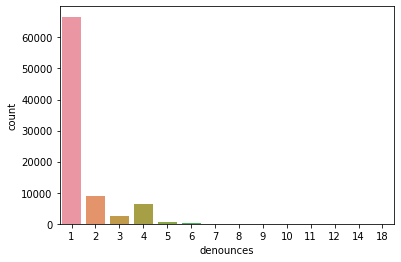

In [62]:
# Distribución de número de denuncias en comentarios denunciados al menos una vez
sns.countplot(denounced.denounces)

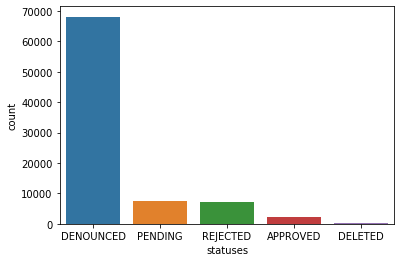

In [64]:
# Distribución de los estados de los comentarios denunciados
sns.countplot(denounced.statuses)

Luego de hacer un análisis de los comentarios de acuerdo a sus estados, algunas conclusiones:

- Existen al menos 85.422 comentarios que se han denunciado alguna vez.
- Si se denuncia un comentario, no necesariamente se invisibiliza, solo se le asigna etiqueta `DENOUNCED`.
- Un comentario se invisibiliza si es que pasa a estado `PENDING`.
En este estado *alguien* revisa el comentario y determina si corresponde asignarle etiqueta `REJECTED` o `APPROVED`.
- Un comentario pasa a estado `PENDING` si: i) es denunciado más de 3 veces, ii) es posteado en alguna noticia marcada como polémica, iii) tiene imágenes embebidas, iv) contiene algún token prohibido. Existen algunas excepciones a la primera regla.
- La etiqueta `DELETED` se aplica si es que el autor de algún comentario lo borra.

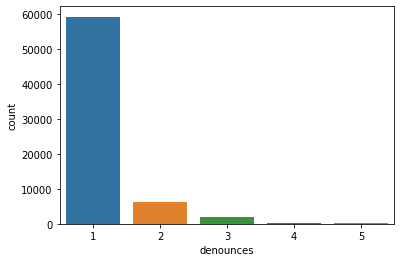

In [74]:
# Distribución del número de denuncias de los posts denunciados con etiqueta DENOUNCED.
# => la mayoría de comentarios DENOUNCED tienen 1, 2 ó 3 denuncias. ~300 no cumplen la regla.
sns.countplot(denounced[denounced.statuses == "DENOUNCED"].denounces)

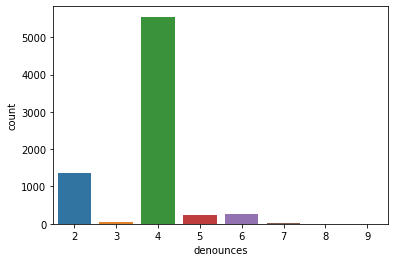

In [76]:
# Distribución del número de denuncias de los posts denunciados con etiqueta PENDING.
# => se observa un incremento a partir de 4 denuncias.
# => tiene sentido que el peak sea ahí porque luego se invisibiliza el comentario, i.e. no se puede seguir denunciando.
# => las excepciones > 4 pueden deberse a que quizás antes no se invisibilizaban automáticamente.
sns.countplot(denounced[denounced.statuses == "PENDING"].denounces)

In [96]:
# Máscaras para calcular probabilidades
pending_mask = denounced.statuses == "PENDING"
denounced_mask = denounced.statuses == "DENOUNCED"
rejected_mask = denounced.statuses == "REJECTED"
approved_mask = denounced.statuses == "APPROVED"
deleted_mask = denounced.statuses == "DELETED"

In [107]:
# Probabilidad de ser invisibilizado, dado que fue denunciado
invisible_df = denounced[pending_mask | rejected_mask]
num_invisible = len(invisible_df)
num_invisible, num_invisible / num_denounced

(14726, 0.17239118728196484)

In [105]:
# Probabilidad de ser rechazado, dado que fue resuelto
resolved = denounced[rejected_mask | approved_mask]
num_resolved = len(resolved)
rejected = denounced[rejected_mask]
num_rejected = len(rejected)
num_rejected, num_rejected / num_resolved

(7220, 0.7612821594264023)

In [106]:
# Probabilidad de ser aprobado, dado que fue resuelto
approved = denounced[approved_mask]
num_approved = len(approved)
num_approved, num_approved / num_resolved

(2264, 0.23871784057359763)

## Revisar actividad en función del tiempo
A continuación se realizará un análisis para determinar la variación de la actividad a lo largo de los años comprendidos en el dataset

In [199]:
def group_by_month_year(df):
    series = df.groupby([df.dates.dt.year, df.dates.dt.month]).size()
    series.index = [f"{idx[0]}-{idx[1]:>02d}" for idx in series.index]
    return series

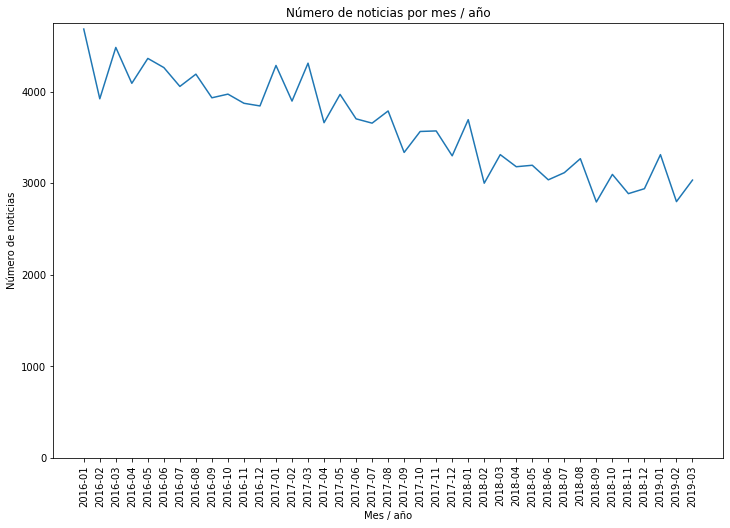

In [211]:
import matplotlib
import matplotlib.pyplot as plt


# Noticias por mes / año
fig = plt.figure(figsize=(12, 8))
news_by_month_year = group_by_month_year(news_df)[:-1]
ax = sns.lineplot(data=news_by_month_year)
ax.set_title("Número de noticias por mes / año")
ax.set_xlabel("Mes / año")
ax.set_ylabel("Número de noticias")
plt.ylim(0, 4750)
plt.xticks(rotation=90)
pass

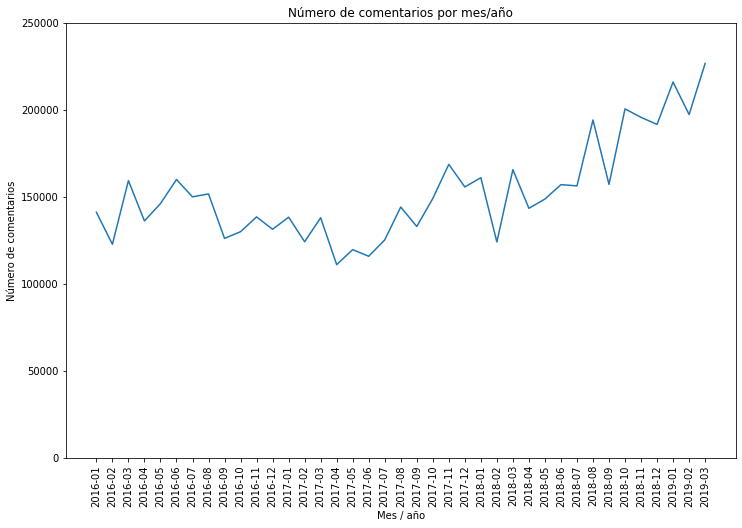

In [210]:
# Comentarios por mes / año

fig = plt.figure(figsize=(12, 8))
comments_by_month_year = group_by_month_year(comments_df)[:-1]
ax = sns.lineplot(data=comments_by_month_year)
ax.set_title("Número de comentarios por mes/año")
ax.set_xlabel("Mes / año")
ax.set_ylabel("Número de comentarios")
plt.ylim(0, 250000)
plt.xticks(rotation=90)
pass

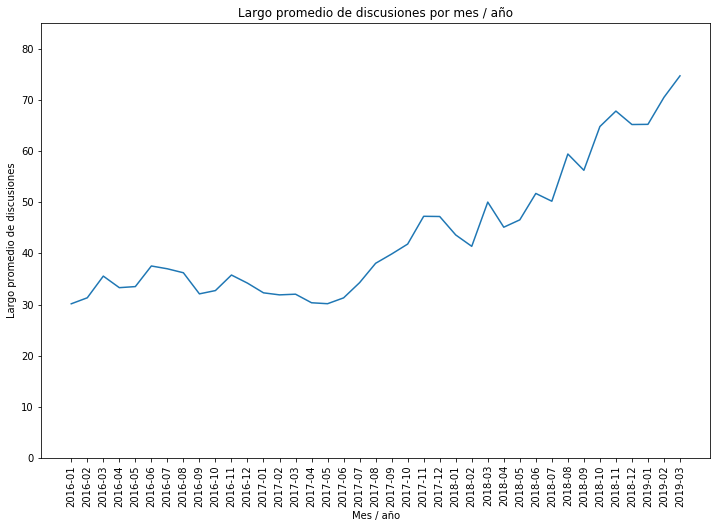

In [230]:
# Largo de discusiones por mes / año
num_comments_per_month_year = news_df.groupby([news_df.dates.dt.year, news_df.dates.dt.month])["num_comments"].mean()
num_comments_per_month_year.index = [f"{idx[0]}-{idx[1]:>02d}" for idx in num_comments_per_month_year.index]

fig = plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=num_comments_per_month_year[:-1])
ax.set_title("Largo promedio de discusiones por mes / año")
ax.set_xlabel("Mes / año")
ax.set_ylabel("Largo promedio de discusiones")
plt.ylim(0, 85)
plt.xticks(rotation=90)
pass

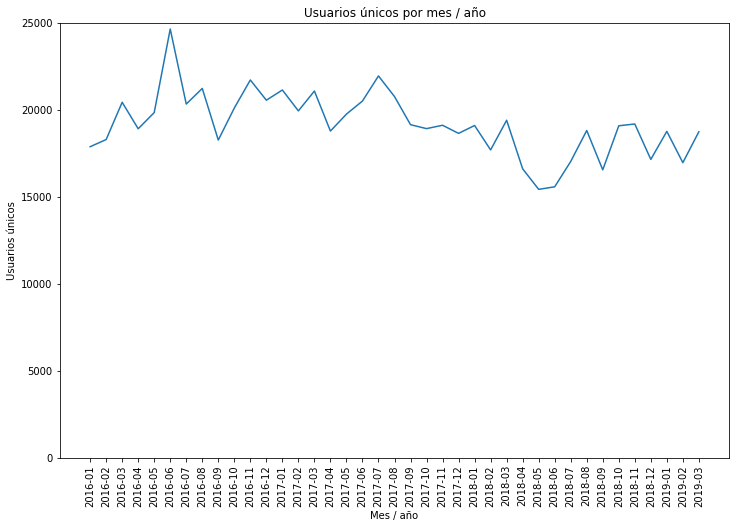

In [228]:
unique_users_per_month_year = comments_df.groupby([comments_df.dates.dt.year, comments_df.dates.dt.month])["creatorIDs"].nunique()
unique_users_per_month_year.index = [f"{idx[0]}-{idx[1]:>02d}" for idx in unique_users_per_month_year.index]

fig = plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=unique_users_per_month_year[:-1])
ax.set_title("Usuarios únicos por mes / año")
ax.set_xlabel("Mes / año")
ax.set_ylabel("Usuarios únicos")
plt.ylim(0, 25000)
plt.xticks(rotation=90)
pass